In [75]:
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from a345_utilities import print_header, mem_usage     
from matplotlib.patches import Rectangle as rect 
import numpy as np
import os, time
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture
from a345_utilities import print_header 
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.coordinates import SkyCoord
from photutils import CircularAnnulus
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting
from astropy.time import Time
import re
import warnings
warnings.filterwarnings('ignore')
from astropy.stats import sigma_clipped_stats




from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError
ast = AstrometryNet()
ast.API_URL = 'http://nova.astro.gla.ac.uk/api' # local server
ast.api_key = 'XXXXXXXX'
ast.URL = 'http://nova.astro.gla.ac.uk'


#API access of the remote server
ast = AstrometryNet()
ast.API_URL = 'http://nova.astrometry.net/api' # local server
ast.URL = 'http://nova.astrometry.net'
#API key for Giles Hammond
ast.api_key = 'cyilczrjxdbmnhum'

In [35]:
filename = '/data/observatory/student_data/2660135R/W_UMa/Chr_G_Corrected/'
with fits.open('W_Uma/dark_flat_gr_3s_master.fits') as hdu:
    flatdark_header = hdu[0].header
    flatdark_data = hdu[0].data

with fits.open('W_Uma/dark_10s_master.fits') as hdu:
    dark_header = hdu[0].header
    dark_data = hdu[0].data

with fits.open('W_Uma/flat_g_master.fits') as hdu:
    flat_g_header = hdu[0].header
    flat_g_data = hdu[0].data

with fits.open('W_Uma/flat_i_master.fits') as hdu:
    flat_i_header = hdu[0].header
    flat_i_data = hdu[0].data

with fits.open('W_Uma/flat_r_master.fits') as hdu:
    flat_r_header = hdu[0].header
    flat_r_data = hdu[0].data

path = ('../../examples/a345/lab_projects/shared-data/remote_telescope/data/cropped_1000x1000/images/Variable Star/W UMa/Chr G/') 

W_UMa_chrg = os.listdir(path)
# print(W_UMa_chrg)

for img in W_UMa_chrg:
    if re.search('_E_',img):
        continue
        
    
    if img.endswith('.fits'):

#         if re.search('_W_',img):
#             print(img)
#             img = np.rot90(img)
#             img = np.rot90(img)
            
        with fits.open(path+img) as hdu:
            img_header = hdu[0].header
            img_data = hdu[0].data      
            img_c = (img_data-dark_data)*(np.mean(flat_g_data-flatdark_data))/(flat_g_data-flatdark_data)
            bkg_sigma = mad_std(img_c)     
            i_mean = np.mean(img_c);     
            i_std  = np.std(img_c);     
            image_min = i_mean - i_std/2    
            image_max = i_mean + i_std/2  
            daofind = DAOStarFinder(fwhm=6, threshold=12*bkg_sigma)  
            sources = daofind(img_c)
            for col in sources.colnames:  
                sources[col].info.format = '%.8g'    
            sources.sort('flux')
            sources.reverse()
            image_width, image_height = img_c.shape
            wcs_header = None            
            t_start = time.time()
            try:
                print('Sending data to AstrometryNet server:')
                wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                                        image_width, image_height,
                                                        solve_timeout=300)
                if wcs_header:   
                    print('\n -> Success. Solving took {:0.1f}s'.format(time.time()-t_start))

                else:
                    print('\n -> Solving failed after {:0.1f}s'.format(time.time()-t_start))       
            except TimeoutError:

                print('Fail')

            img_header.update(wcs_header)          
            hdu = fits.PrimaryHDU()        
            hdu.data = img_c
            hdu.header = img_header
            hdu.header.update(wcs_header)       
            hdu.writeto(filename+'corrected'+img, overwrite=True)

Sending data to AstrometryNet server:
Solving...
 -> Success. Solving took 5.2s
Sending data to AstrometryNet server:
Solving....
 -> Success. Solving took 6.4s
Sending data to AstrometryNet server:
Solving.........
 -> Success. Solving took 12.7s
Sending data to AstrometryNet server:
Solving...
 -> Success. Solving took 5.2s
Sending data to AstrometryNet server:
Solving....
 -> Success. Solving took 6.6s
Sending data to AstrometryNet server:
Solving...
 -> Success. Solving took 5.3s
Sending data to AstrometryNet server:
Solving...
 -> Success. Solving took 5.4s
Sending data to AstrometryNet server:
Solving........
 -> Success. Solving took 11.3s
Sending data to AstrometryNet server:
Solving....
 -> Success. Solving took 6.8s
Sending data to AstrometryNet server:
Solving........
 -> Success. Solving took 11.2s
Sending data to AstrometryNet server:
Solving.........
 -> Success. Solving took 12.5s
Sending data to AstrometryNet server:
Solving...
 -> Success. Solving took 5.2s
Sending dat

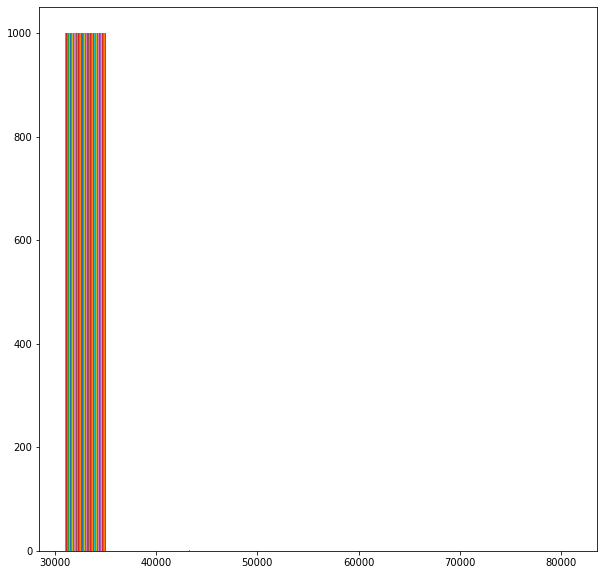

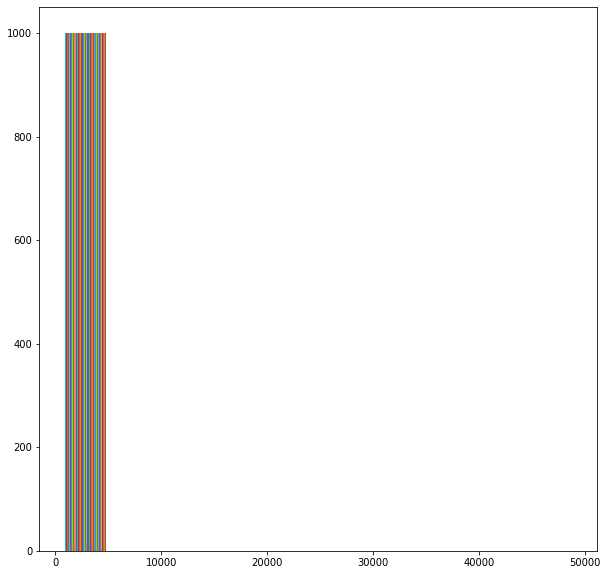

In [19]:
with fits.open(filename+'correctedW-UMa_LIGHT_2024-01-23T20-55-56Z_Chr-G_10s_-10.0C_W_0007.fits') as hdu:
        img_corrected_head = hdu[0].header
        img_corrected_data = hdu[0].data   
        
with fits.open(path+'W-UMa_LIGHT_2024-01-23T20-55-56Z_Chr-G_10s_-10.0C_W_0007.fits') as hdu:
        img_head = hdu[0].header
        img_data = hdu[0].data    
     
plt.figure(figsize = (10,10))
plt.hist(img_corrected_data)
plt.show()

plt.figure(figsize = (10,10))
plt.hist(img_data)
plt.show()

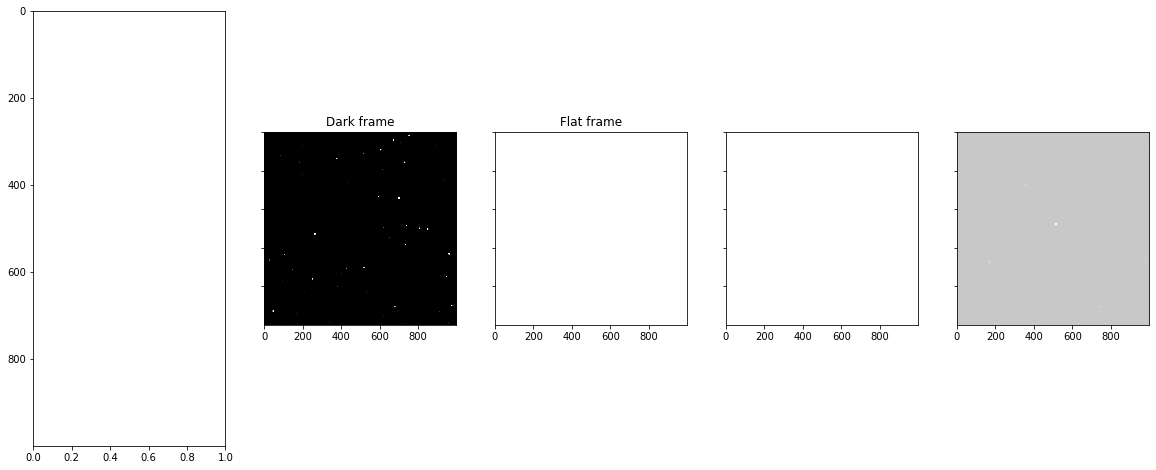

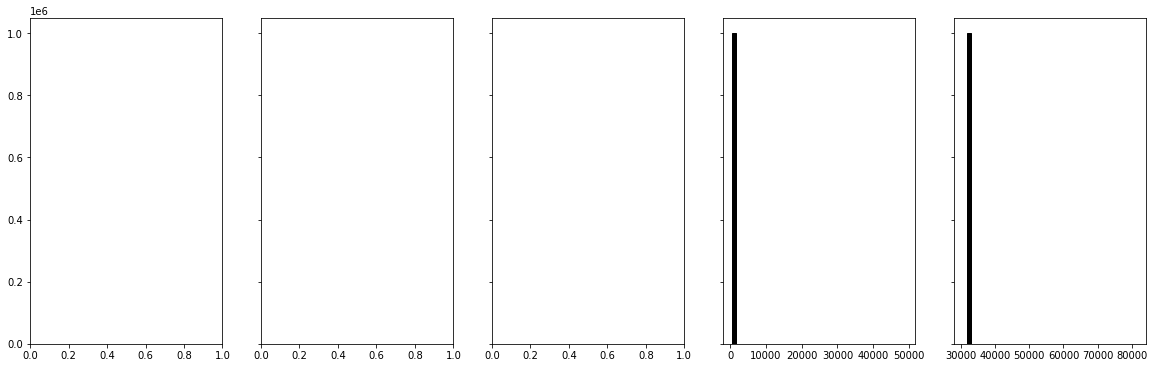

In [34]:
# Plot the calibration images, limiting the colour range to show detail. Also plot a small area zoomed in to show the pixel level variations    
bias_min = 405; bias_max = 425
dark_min = 405; dark_max = 425
flat_min = 25000; flat_max = 35000
data_min = 300; data_max = 600

nbins = 40

f1, (ax_flatdark, ax_dark, ax_flat,ax_data,ax_datac) = plt.subplots(1, 5, sharey=True, figsize=(20,8))
plot_flatdark = ax_bias.imshow(flatdark_data, vmin = bias_min, vmax=bias_max, cmap='gray')
plot_dark = ax_dark.imshow(dark_data, vmin = dark_min, vmax=dark_max, cmap='gray')
plot_flat = ax_flat.imshow(flat_g_data, vmin = flat_min, vmax=flat_max, cmap='gray')
plot_data = ax_data.imshow(img_data, vmin = dark_min, vmax=dark_max, cmap='gray')
plot_c_data = ax_datac.imshow(img_corrected_data, vmin = flat_min, vmax=flat_max, cmap='gray')
ax_bias.set_title('Bias frame')
ax_dark.set_title('Dark frame')
ax_flat.set_title('Flat frame')

# zoom in on a subregion to show pixels

p=[1500,2000]                   
w=100; h=60;
ax_flatdark.add_patch(rect(p,w,h, edgecolor = 'firebrick', fill=False))
ax_dark.add_patch(rect(p,w,h, edgecolor = 'firebrick', fill=False))
ax_flat.add_patch(rect(p,w,h, edgecolor = 'firebrick', fill=False))
ax_data.add_patch(rect(p,w,h, edgecolor = 'firebrick', fill=False))
ax_datac.add_patch(rect(p,w,h, edgecolor = 'firebrick', fill=False))
# f2, (ax_bias_sub, ax_dark_sub, ax_flat_sub) = plt.subplots(1, 3, sharey=True, figsize=(20,8))
#f2, (ax_bias_sub, ax_dark_sub, ax_flat_sub) = plt.subplots(1, 3, sharey=True)

# ax_flatdark_sub.imshow(flatdark_data[p[1]:p[1]+h,p[0]:p[0]+w], vmin = bias_min, vmax=bias_max, cmap='gray', interpolation="none")
# ax_dark_sub.imshow(dark_data[p[1]:p[1]+h,p[0]:p[0]+w], vmin = dark_min, vmax=dark_max, cmap='gray', interpolation="none")
# ax_flat_sub.imshow(flat_g_data[p[1]:p[1]+h,p[0]:p[0]+w], vmin = flat_min, vmax=flat_max, cmap='gray', interpolation="none")
# ax_data_sub.imshow(img_data[p[1]:p[1]+h,p[0]:p[0]+w], vmin = dark_min, vmax=dark_max, cmap='gray', interpolation="none")
# ax_datac_sub.imshow(img_corrected_data[p[1]:p[1]+h,p[0]:p[0]+w], vmin = flat_min, vmax=flat_max, cmap='gray', interpolation="none")

f3, (ax_flatdark_hist, ax_dark_hist, ax_flat_hist,ax_data_hist, ax_datac_hist) = plt.subplots(1, 5, sharey=True, figsize=(20,6))

# ax_flatdark_hist.hist(flatdark_data.flatten(), bins=nbins, range=(bias_min, bias_max), fc='k', ec='k');
# ax_dark_hist.hist(dark_data.flatten(), bins=nbins, range=(dark_min, dark_max), fc='k', ec='k');
# ax_flat_hist.hist(flat_g_data.flatten(), bins=40, range=(flat_min, flat_max), fc='k', ec='k');
ax_data_hist.hist(img_data.flatten(), bins=nbins, fc='k', ec='k');
ax_datac_hist.hist(img_corrected_data.flatten(), bins=40, fc='k', ec='k');

In [73]:
N_source = 20

N_cal = 3
data_cal = np.transpose(np.loadtxt("W_Uma/Calibration_Stars.txt", skiprows=1, delimiter=","))
id_cal=data_cal[0]
mag_cal=data_cal[3]
ra_cal=data_cal[1]
dec_cal=data_cal[2]
id_cal1 = id_cal[..., None] 
mag_cal1 = mag_cal[..., None] 
ra_cal1 = ra_cal[..., None] 
dec_cal1 = dec_cal[..., None] 
r1=19
r2=r1+1
r3=r2+4
# print(os.listdir(filename

for img in os.listdir(filename):
    if re.search('check',img):
        continue  
    with fits.open(filename+img) as hdu:
            img_header = hdu[0].header
            img = hdu[0].data 
    
    
    bkg_sigma = mad_std(img)     
    i_mean = np.mean(img);     
    i_std  = np.std(img);     
    image_min = i_mean - i_std/2    
    image_max = i_mean + i_std/2  
    daofind = DAOStarFinder(fwhm=6, threshold=12*bkg_sigma)  
    sources = daofind(img)
    for col in sources.colnames:  
        sources[col].info.format = '%.8g'    
    sources.sort('flux')
    sources.reverse()
    
   

    wcs = WCS(img_header)


    
#     positions_dao = np.transpose((sources['xcentroid'][0], sources['ycentroid'][0]))  
#     apertures_define = CircularAperture(positions_dao, r=25)
#     apertures_dao=apertures_define[0:N_source+1]


#     # plot id labels on the figure which match thos eof DAO starfinder
#     for j,p in enumerate(positions_dao[0:N_source+1]):
#         plt.text(p[0]+10,p[1],sources['id'][j],fontsize=20,color='yellow')


    # calibration stars
    source1_x, source1_y= wcs.wcs_world2pix(ra_cal,dec_cal,1)
    source1 = np.transpose((source1_x, source1_y))
    source1_aperture = CircularAperture(source1, r1)  
    source1_annulus = CircularAnnulus(source1, r2, r3)
    source1_phot = [source1_aperture, source1_annulus]

    for k in range(N_cal):
        plt.text(source1_x[k]-50,source1_y[k]-50,id_cal[k],fontsize=14,color='blue')




        #aperture photo,etry of sources
    Coor_x, Coor_y = wcs.wcs_pix2world(sources['xcentroid'], sources['ycentroid'], 1)
    # sky_Coor=SkyCoord(Coor_x*u.degree,Coor_y*u.degree)  
    source2=np.transpose((Coor_x, Coor_y))
    source2_aperture = CircularAperture(source2, r1)  
    source2_annulus = CircularAnnulus(source2, r2, r3)
    source2_phot = [source2_aperture, source2_annulus]



    # APERTURE PHOTOMETRY

    phot_table_source1 = aperture_photometry(img, source1_phot) #calibration 
    phot_table_source2 = aperture_photometry(img, source2_phot) #sources

    for col in phot_table_source1.colnames:
        phot_table_source1[col].info.format = '%.8g'  # for consistent table output
   # print(phot_table_source1)

    #print('************ Cal 1/Cal 2 *************')
    bkg_mean_cal1 = float(phot_table_source1[0]['aperture_sum_1'] / source1_annulus.area)
    bkg_mean_cal2 = float(phot_table_source1[1]['aperture_sum_1'] / source1_annulus.area)

    #print('mean bkg Cal 1=',bkg_mean_cal1)
    #print('mean bkg Cal 2=',bkg_mean_cal2)

    bcal1 = bkg_mean_cal1 * source1_aperture.area
    bcal2 = bkg_mean_cal2 * source1_aperture.area
    # background removed counts
    cal1_flux=float(phot_table_source1[0]['aperture_sum_0'] - bcal1)
    cal2_flux=float(phot_table_source1[1]['aperture_sum_0'] - bcal2)

    #print('Cal 1 flux=', cal1_flux)
    #print('Cal 2 flux=', cal2_flux)

    # phot_table_source2 = aperture_photometry(image_c, source2_phot)
    for col in phot_table_source2.colnames:
        phot_table_source2[col].info.format = '%.8g'  # for consistent table output
    #print(phot_table_source2)

    #print('************ Target *************')
    bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)

   # print('mean bkg target=',bkg_mean_targ)

    targcal = bkg_mean_targ * source2_aperture.area
    # background removed counts
    targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)
    #print('Target flux=', targ_flux)

    # mag_cal=mag_cal1[0,0] + 2.5*np.log10(cal1_flux/cal2_flux)
    mag_targ=mag_cal1[0,0] + 2.5*np.log10(cal1_flux/targ_flux)

    #print('......')

    t_fits=hdu[0].header['DATE-OBS']
    t = Time(t_fits, format='isot', scale='utc')
    t_jd=t.jd 

    print(mag_targ)



16.186425256918923
nan
16.48050986792288
16.23535833320862
nan
16.728360921315712
15.87250226612866
15.880925722467879
19.21941084483736
nan
nan
15.721708731210962
16.66886552028569
nan
nan
nan
16.49262645366756
nan
19.060163052301508
16.27460378518123
nan
17.550611461503216
nan
nan
nan
nan
16.98597658147681
nan
nan
15.791474883112421
17.978331945306845
nan
18.37795016089011
16.346444781703305
nan
nan
15.823793820905621
16.734073582129263
nan
nan


ValueError: Image size of 234787x188118 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [82]:
target_jd = []
target_mags = []



for img in W_UMa_chrg:
    if re.search('_E_',img):
        continue    
    if img.endswith('.fits'):          
        with fits.open(path+img) as hdu:
            img_header = hdu[0].header
            img_data = hdu[0].data      
    img_c = (img_data-dark_data)*(np.mean(flat_g_data-flatdark_data))/(flat_g_data-flatdark_data)
    mean, median, std = sigma_clipped_stats(img_c, sigma=3.0)
    daofind = DAOStarFinder(fwhm=4, threshold=6*std)  
    sources = daofind(img_c)

    for col in sources.colnames:  
        sources[col].info.format = '%.8g'  # for consistent table output  
    # sort the sources on flux
    sources.sort('flux')
    # reverse to get brightest objects first
    sources.reverse()
    #print(len(sources))
    #print(sources)

    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++

    wcs_header = None 
    wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                            img_c.shape[1], 
                                            img_c.shape[0],
                                            #scale_est =  0.724,
                                            #scale_units = 'arcsecperpix',
                                            solve_timeout=1200)
    if wcs_header:
        print('Success')
    else:
        print('Failed') 

    # add in the header containg the wcs data
    img_header.update(wcs_header)
    hdu = fits.PrimaryHDU()
    hdu.header.update(img_header)       
    hdu.data = img_c
    hdu.writeto(filename+'corrected'+img, overwrite=True)
    wcs = WCS(img_header)

    # save to a new FITS file
    with fits.open(filename+'corrected'+img) as hdu:
        reloaded_header = hdu[0].header
        reloaded_data   = hdu[0].data
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++
    # plot the solved image using the wcs projection

    ax = plt.subplot(projection=wcs)
    plt.rcParams['figure.figsize'] = [25,25]
    ax = plt.gca()
    RA = ax.coords[0]
    DEC = ax.coords[1]

    RA.set_ticklabel(color='black', size=20)
    DEC.set_ticklabel(color='black', size=20)
    ax.set_xlabel('RA', fontsize=20)
    ax.set_ylabel('Dec', fontsize=20)
    ax.set_title('DAO starfinder sources (yellow), calibration stars (blue) and test target (red)',size=20)

    #plt.imshow(image_c, vmin=image_min,vmax=image_max,cmap='gray_r')
    plt.grid(color='white', ls='solid',linewidth=2)
    RA.set_ticks(number=10)
    DEC.set_ticks(number=10)

    # number of sources from DAO Starfinder to plot
    N_source=20
    # number of calibration stars to plot
    N_cal=3

    data_cal = np.transpose(np.loadtxt("W_Uma/Calibration_Stars.txt", skiprows=1, delimiter=","))
    id_cal=data_cal[0]
    mag_cal=data_cal[3]
    ra_cal=data_cal[1]
    dec_cal=data_cal[2]

    id_cal1 = id_cal[..., None] 
    mag_cal1 = mag_cal[..., None] 
    ra_cal1 = ra_cal[..., None] 
    dec_cal1 = dec_cal[..., None] 

    # plot yellow circles around the sources found by DAO starfinder
    positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures_define = CircularAperture(positions_dao, r=25)
    apertures_dao=apertures_define[0:N_source+1]
    apertures_dao.plot(color='yellow', lw=1, alpha=1)

    # plot id labels on the figure which match thos eof DAO starfinder
    for j,p in enumerate(positions_dao[0:N_source+1]):
        plt.text(p[0]+10,p[1],sources['id'][j],fontsize=20,color='yellow')

    r1=12
    r2=r1+1
    r3=r2+4

    # plot blue circles around the calibration stars from VizieR
    source1_x, source1_y= wcs.wcs_world2pix(ra_cal,dec_cal,1)
    source1 = np.transpose((source1_x, source1_y))
    source1_aperture = CircularAperture(source1, r1)  
    source1_annulus = CircularAnnulus(source1, r2, r3)

    source1_phot = [source1_aperture, source1_annulus]
    source1_aperture.plot(color='blue', lw=2, alpha=1)
    source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)

    for k in range(N_cal):
        plt.text(source1_x[k]-50,source1_y[k]-50,id_cal[k],fontsize=14,color='blue')

    # plot cyan circle around target asteroid
    #source2_x, source2_y = wcs.wcs_world2pix(15*(7+23/60+35.6/3600),29+43/60+45/3600, 1)

    source2_x, source2_y =(sources['xcentroid'] , sources['ycentroid'] )

    Coor_x, Coor_y = wcs.wcs_pix2world(source2_x, source2_y, 1)
    #print(source2_x,source2_y)
    #print(Coor_x,Coor_y)
    #sky_Coor=SkyCoord(Coor_x*u.degree,Coor_y*u.degree)
    #print(sky_Coor.to_string('hmsdms'))

    #obj_asteroid = np.transpose((pixel_x, pixel_y))  
    source2=np.transpose((source2_x, source2_y))
    source2_aperture = CircularAperture(source2, r1)  
    source2_aperture.plot(color='red', lw=2, alpha=1)

    source2 = np.transpose((source2_x, source2_y))
    source2_aperture = CircularAperture(source2, r1)  
    source2_annulus = CircularAnnulus(source2, r2, r3)

    source2_phot = [source2_aperture, source2_annulus]
    #source2_aperture.plot(color='red', lw=2, alpha=1)
    #source2_annulus.plot(color='lightcoral', lw=2, alpha=1)



#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++APERTURE PHOTOMETRY+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    phot_table_source1 = aperture_photometry(img_c, source1_phot)
    phot_table_source2 = aperture_photometry(img_c, source2_phot)

    for col in phot_table_source1.colnames:
        phot_table_source1[col].info.format = '%.8g'  # for consistent table output

    #print('************ Cal 1/Cal 2 *************')
    bkg_mean_cal1 = float(phot_table_source1[0]['aperture_sum_1'] / source1_annulus.area)
    bkg_mean_cal2 = float(phot_table_source1[1]['aperture_sum_1'] / source1_annulus.area)

    bcal1 = bkg_mean_cal1 * source1_aperture.area
    bcal2 = bkg_mean_cal2 * source1_aperture.area
    # background removed counts
    cal1_flux=float(phot_table_source1[0]['aperture_sum_0'] - bcal1)
    cal2_flux=float(phot_table_source1[1]['aperture_sum_0'] - bcal2)

    for col in phot_table_source2.colnames:
        phot_table_source2[col].info.format = '%.8g'  # for consistent table output


    #print('************ Target *************')
    bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)



    targcal = bkg_mean_targ * source2_aperture.area

    targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)

    mag_targ=mag_cal1[0,0] + 2.5*np.log10(cal1_flux/targ_flux)

    t_fits=hdu[0].header['DATE-OBS']
    t = Time(t_fits, format='isot', scale='utc')
    t_jd=t.jd 
    target_mags.append(mag_targ)
    target_jd.append(t_jd)
    print(mag_targ)

Solving........Success
8.43539161220054
Solving.....Success
7.975290390154849
Solving......Success
8.140335990805179
Solving......Success
8.43539161220054
Solving........Success
8.164511573675703
Solving..........Success
8.605649141180825
Solving......Success
8.012598239050178
Solving.......Success
8.021788525137737
Solving....Success
8.021788525137737
Solving........Success
8.676257294007259
Solving.......Success
8.06170603165845
Solving.........Success
8.22531349006795
Solving.....Success
8.182552682822013
Solving.....Success
8.541334073433232
Solving....Success
8.714808434971916
Solving...Success
8.362152667189964
Solving.........Success
8.109099081948603
Solving.........Success
8.614463594086658
Solving.....Success
8.328990112290755
Solving............Success
8.369819514181312
Solving.........Success
8.350798687321479
Solving........Success
7.981744762752566
Solving...Success
8.079145314855444
Solving........Success
8.47164907773772
Solving.....Success
8.38676644757446
Solving....S

ValueError: Image size of 1405987x1355410 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x1800 with 1 Axes>

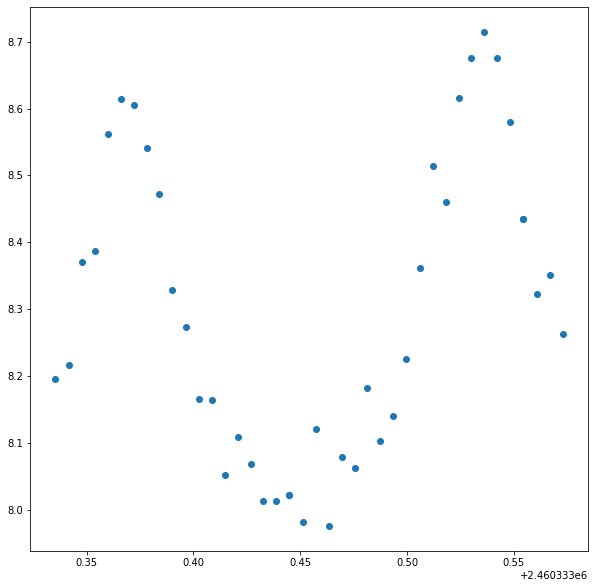

In [85]:
plt.figure(figsize=(10,10))
plt.scatter(target_jd,target_mags)
plt.show()

In [138]:
path_cal = '../../examples/a345/lab_projects/shared-data/remote_telescope/data/cropped_1000x1000/calibration/2023-10/neg10c/master'
path_data =  '../../examples/a345/lab_projects/shared-data/remote_telescope/data/cropped_1000x1000/images/Variable Star'
target_jd = []
target_mags = []


def light_curve(star,band:str,exposure:str):
    '''
    Function to calibrate raw fits files, plate solve and extract magnitudes
    Star is a string
    Band is the colour band 
    Exposure is the exposure time in seconds (time with s)
    '''
    counter = 0
    with fits.open(path_cal+'/dark_flat_gr_3s_master.fits') as hdu:
        flatdark_data = hdu[0].data
    
    with fits.open(path_cal+'/dark_'+exposure+'_master.fits') as hdu:
        dark_data = hdu[0].data
   
    if re.search('G',band):
        with fits.open(path_cal+'/flat_g_master.fits') as hdu:
            flat = hdu[0].data      
    
    if re.search('I',band):
        with fits.open(path_cal+'/flat_i_master.fits') as hdu:
            flat = hdu[0].data 
    
    if re.search('R',band):
        with fits.open(path_cal+'/flat_r_master.fits') as hdu:
            flat = hdu[0].data 
    
    star_list = os.listdir(path_data+'/'+star+'/'+band)       
   
    for img in star_list:
        if re.search('_E_',img):
            continue    
        if img.endswith('.fits'):          
            with fits.open(path_data+'/'+star+'/'+band+'/'+img) as hdu:
                img_header = hdu[0].header
                img_data = hdu[0].data      
            img_c = (img_data-dark_data)*(np.mean(flat-flatdark_data))/(flat-flatdark_data)
            mean, median, std = sigma_clipped_stats(img_c, sigma=3.0)
            daofind = DAOStarFinder(fwhm=4, threshold=6*std)  
            sources = daofind(img_c)

            for col in sources.colnames:  
                sources[col].info.format = '%.8g'
            sources.sort('flux')
            sources.reverse()
 #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++
            wcs_header = None 
            wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                                    img_c.shape[1], 
                                                    img_c.shape[0],
                                                    #scale_est =  0.724,
                                                    #scale_units = 'arcsecperpix',
                                                    solve_timeout=1200)
            if wcs_header:
                print('Success')
            else:
                print('Failed') 
            
            img_header.update(wcs_header)
            if counter == 0:
                
                print(img_header['OBJCTDEC'],img_header['OBJCTRA'])
            hdu = fits.PrimaryHDU()
            hdu.header.update(img_header)       
            hdu.data = img_c
            hdu.writeto(filename+'corrected'+img, overwrite=True)
            wcs = WCS(img_header)
            with fits.open(filename+'corrected'+img) as hdu:
                reloaded_header = hdu[0].header
                reloaded_data   = hdu[0].data
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++PLATE SOLVING++++++++++++++++++++++++++++++++++++++++++++++++++++
            # number of sources from DAO Starfinder to plot
            N_source=20
            # number of calibration stars to plot
            N_cal=3

            data_cal = np.transpose(np.loadtxt(star+'/Calibration_Stars.txt', skiprows=1, delimiter=","))
            id_cal=data_cal[0]
            mag_cal=data_cal[3]
            ra_cal=data_cal[1]
            dec_cal=data_cal[2]

            id_cal1 = id_cal[..., None] 
            mag_cal1 = mag_cal[..., None] 
            ra_cal1 = ra_cal[..., None] 
            dec_cal1 = dec_cal[..., None] 

            # plot yellow circles around the sources found by DAO starfinder
            positions_dao = np.transpose((sources['xcentroid'], sources['ycentroid']))  
            apertures_define = CircularAperture(positions_dao, r=25)
            apertures_dao=apertures_define[0:N_source+1]
            apertures_dao.plot(color='yellow', lw=1, alpha=1)

            # plot id labels on the figure which match thos eof DAO starfinder
            for j,p in enumerate(positions_dao[0:N_source+1]):
                plt.text(p[0]+10,p[1],sources['id'][j],fontsize=20,color='yellow')

            r1=12
            r2=r1+1
            r3=r2+4

            # plot blue circles around the calibration stars from VizieR
            source1_x, source1_y= wcs.wcs_world2pix(ra_cal,dec_cal,1)
            source1 = np.transpose((source1_x, source1_y))
            source1_aperture = CircularAperture(source1, r1)  
            source1_annulus = CircularAnnulus(source1, r2, r3)

            source1_phot = [source1_aperture, source1_annulus]
            source1_aperture.plot(color='blue', lw=2, alpha=1)
            source1_annulus.plot(color='deepskyblue', lw=2, alpha=1)

            for k in range(N_cal):
                plt.text(source1_x[k]-50,source1_y[k]-50,id_cal[k],fontsize=14,color='blue')

            # plot cyan circle around target asteroid
            #source2_x, source2_y = wcs.wcs_world2pix(15*(7+23/60+35.6/3600),29+43/60+45/3600, 1)

            source2_x, source2_y =(sources['xcentroid'] , sources['ycentroid'] )

            Coor_x, Coor_y = wcs.wcs_pix2world(source2_x, source2_y, 1) 
            source2=np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            source2_aperture.plot(color='red', lw=2, alpha=1)

            source2 = np.transpose((source2_x, source2_y))
            source2_aperture = CircularAperture(source2, r1)  
            source2_annulus = CircularAnnulus(source2, r2, r3)

            source2_phot = [source2_aperture, source2_annulus]
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++APERTURE PHOTOMETRY+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

            phot_table_source1 = aperture_photometry(img_c, source1_phot)
            phot_table_source2 = aperture_photometry(img_c, source2_phot)

            for col in phot_table_source1.colnames:
                phot_table_source1[col].info.format = '%.8g'  # for consistent table output

            bkg_mean_cal1 = float(phot_table_source1[0]['aperture_sum_1'] / source1_annulus.area)
            bkg_mean_cal2 = float(phot_table_source1[1]['aperture_sum_1'] / source1_annulus.area)

            bcal1 = bkg_mean_cal1 * source1_aperture.area
            bcal2 = bkg_mean_cal2 * source1_aperture.area

            cal1_flux=float(phot_table_source1[0]['aperture_sum_0'] - bcal1)
            cal2_flux=float(phot_table_source1[1]['aperture_sum_0'] - bcal2)

            for col in phot_table_source2.colnames:
                phot_table_source2[col].info.format = '%.8g'  # for consistent table output

            bkg_mean_targ = float(phot_table_source2[0]['aperture_sum_1'] / source2_annulus.area)

            targcal = bkg_mean_targ * source2_aperture.area

            targ_flux=float(phot_table_source2[0]['aperture_sum_0'] - targcal)

            mag_targ=mag_cal1[0,0] + 2.5*np.log10(cal1_flux/targ_flux)

            t_fits=hdu[0].header['DATE-OBS']
            t = Time(t_fits, format='isot', scale='utc')
            t_jd=t.jd 
            target_mags.append(mag_targ)
            target_jd.append(t_jd)
            print(mag_targ)
            counter +=1
    

In [140]:
light_curve('W UMa','CHr I','10s')

Solving......Success
55 57 43.49 09 43 49.387
8.63676569181552
Solving.......Success
8.384368101512834
Solving........Success
8.198522158437923
Solving............Success
8.327780078110504
Solving.....Success
8.049141436912432
Solving...........Success
8.566166201170834
Solving...Success
8.032632910197385
Solving...........Success
8.157824080737957
Solving.........Success
8.604176736380143
Solving...Success
8.371043256765608
Solving.......Success
8.636721572389988
Solving..............Success
8.148407094735212
Solving.........Success
8.19837285332495
Solving.......Success
8.691152965412202
Solving........Success
8.445593962342581
Solving........Success
8.278274885061247
Solving.............Success
8.04660541031765
Solving........Success
8.165570997601083
Solving..........Success
8.167699063967454
Solving.......Success
8.571706819098694
Solving................Success
8.306965200798984
Solving...........Success
8.021503257293888
Solving........Success
8.36257696583063
Solving........Succ

ValueError: Image size of 1406473x1356048 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x1800 with 1 Axes>

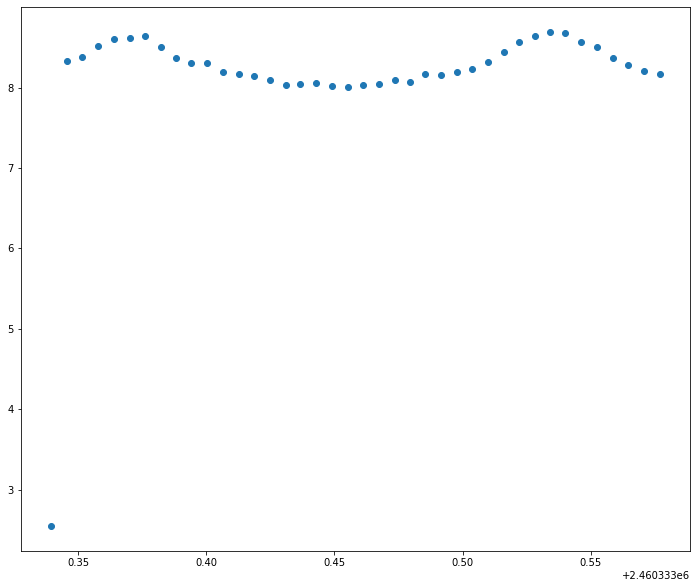

In [141]:
plt.figure(figsize=(12,10))
plt.scatter(target_jd,target_mags)
plt.show()